The find_peaks() function provides a decent result in peak detection task. This project concerns with what can we do to deliver a better performance relative to the scipy package given the dataset.
We have tried multiple possible algorithms and concluded with the following two algorithms: 
1. AMPD
2. wavelet transform (denoising filter) + find_peaks() 

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pywt
from skimage.restoration import denoise_wavelet 

In [2]:
def normalise(data, lower, upper):
    d = np.array(data)
    a, b = min(d), max(d)
    return (upper-lower) * (d - a) / (b - a) + lower, a, b

def reconstruct(data, lower, upper, a, b):
    d = np.array(data)
    return (d - lower) * (b - a) / (upper - lower) + a

In [3]:
def match(peak_ids, peak_values, *args):
    '''
    match peaks among multiple arrays
    *args are the peak_ids of denoised signals
    '''
    selected_peaks = []
    for peaks in args:
        #print(peaks)
        for id in peaks:
            #print(id)
            difference = ((peak_ids-id)**2 + 1) / np.exp(peak_values[peak_ids]) #just a prototype
            matched = np.argmin(difference)
            selected_peaks.append(peak_ids[matched])

    return np.unique(selected_peaks)

In [4]:
def denoise(data, filters_list):
    """
    denoise with a bunch of filters
    a filter will typically be like:
    filter1 = lambda x: denoise_wavelet(x, *args)
    """
    try:
        for filter in filters_list:
            data = filter(data)
        return data
    except ValueError:
         print("no appropriate filters list!")


    
def filters(Wavelets, levels, mode = "hard"):
    if len(Wavelets) != len(levels):
        raise IndexError("Wavelets and levels not match in length!")
            
    filters_list = []
    for i, wav in enumerate(Wavelets):
        ftr = lambda x: denoise_wavelet(x, wavelet=wav, wavelet_levels=levels[i], mode=mode)
        filters_list.append(ftr)
    return filters_list 

##### automatic multiscale-based peak detection (AMPD)
The paper tried to develop an algorithm that is simple and effective to detect peaks in quasi periodic noisy time series data by  
(i) using a multiscale technique to detect all local maxima of the signal   
(ii) finding the “real peaks” by automatically analyzing the results of the multiscale technique applied.   
Even though our data does not have the property of periodicity, we had decided to experiment with the AMPD algorithm due to its simplicity and effectiveness.   

In [5]:
def AMPD(data):
    """
    实现AMPD算法
    :param data: 1-D numpy.ndarray
    :return: 波峰所在索引值的列表
    """
    p_data = np.zeros_like(data, dtype=np.int32)
    count = data.shape[0]
    arr_rowsum = []
    for k in range(1, count // 2 + 1):
        row_sum = 0
        for i in range(k, count - k):
            if data[i] > data[i - k] and data[i] > data[i + k]:
                row_sum -= 1
        arr_rowsum.append(row_sum)
    min_index = np.argmin(arr_rowsum)
    max_window_length = min_index
    for k in range(1, max_window_length + 1):
        for i in range(k, count - k):
            if data[i] > data[i - k] and data[i] > data[i + k]:
                p_data[i] += 1
    # result_1 = np.where(p_data == max_window_length)[0]
    # arr_rowsum = np.delete(arr_rowsum,min_index)
    # min_index = np.argmin(arr_rowsum)
    # max_window_length = min_index
    # for k in range(1, max_window_length + 1):
    #     for i in range(k, count - k):
    #         if data[i] > data[i - k] and data[i] > data[i + k]:
    #             p_data[i] += 1
    #
    # result_2 = np.where(p_data == max_window_length)[0]
    # return np.concatenate((result_1, result_2))
    return np.where(p_data == max_window_length)[0]

In [6]:
def sweep(data_path, **kwargs):
    '''
    filters: list, the name list of Wavelets that are used for denoising
    levels: list, the int list of levels of correspoding Wavelets denoising
    mode: "hard" or "soft", threshold mode of Wavelet denoising
    scale: bool, whether to process the algorithm after normalizing to [-1,1]
    img_path: str, the os path for final plots
    '''
    for i in [4,5,7,8]:
        with open(data_path.format(i), 'r') as f:
            samples = json.load(f)
        df = pd.DataFrame.from_dict(samples)

        num_output = 0

        for col in df.columns:
            for idx in ['L','R']:
                signals = np.array(df[col][idx], dtype='float32')
                inv_signals = np.negative(signals)

                if signals.size == 1:
                    #empty dataset
                    print(f"empty dataset in {data_path.format(i)}.")
                    continue

                if kwargs.get('scale', True):
                    signals, mi, ma = normalise(signals, -1, 1)

                p, _ = find_peaks(signals)
                # q, _ = find_peaks(signals, prominence=0.1)
                inv_p, _ = find_peaks(inv_signals)
                #inv_q, _ = find_peaks(inv_signals, prominence=0.1)
                g = AMPD(signals)
                inv_g = AMPD(inv_signals)

                # find_peaks(signals)


                if 'filters' in kwargs and 'levels' in kwargs:
                    ftrs = filters(Wavelets=kwargs.get('filters'), levels=kwargs.get('levels'), mode=kwargs.get('mode',"hard"))
                    smooth = denoise(signals, ftrs)
                    p_smooth, _ = find_peaks(smooth, prominence=0.1)
                    inv_p_smooth, _ = find_peaks(np.negative(smooth), prominence=0.1)
                    #match corresponding peaks
                    p_matched = match(p, signals, p_smooth)
                    inv_p_matched = match(inv_p, inv_signals, inv_p_smooth)

                if 'img_path' in kwargs:
                    Wavelets = kwargs.get('filters')[0] + kwargs.get('filters')[1]
                    img_path = kwargs.get('img_path')                    
                    # if not os.path.exists(img_path.format(i)):
                    #     os.makedirs(img_path.format(i))
                    if not os.path.exists(img_path.format(Wavelets)):
                        os.makedirs(img_path.format(Wavelets))
                    
                    signals = reconstruct(signals, -1, 1, mi, ma)
                    smooth = reconstruct(smooth, -1, 1, mi, ma)
                    
                    plt.plot(signals)
                    # plt.plot(smooth,label="Denoised")
                    # plt.xlabel("Time(frame)")
                    # plt.ylabel("Scale")

                    plt.plot(p, signals[p], "o", color='orange', label="find_peaks")
                    plt.plot(inv_p, signals[inv_p], "o", color='orange')
                    # plt.plot(q, signals[q], "x", color='green', label="Peaks with prominence=0.1")
                    # plt.plot(inv_q, signals[inv_q], "rx")

                    # plt.plot(g, signals[g], "s", color='c', label="AMPD")
                    # plt.plot(inv_g, signals[inv_g], "s", color='c')
                    plt.plot(p_matched, signals[p_matched], "*", color='m', label="wave_match")
                    plt.plot(inv_p_matched, signals[inv_p_matched], "*", color='m')

                    plt.xlabel("Time(frame)")
                    plt.ylabel("Scale")
                    if (idx=="L"):
                        plt.title("Left")
                    else:
                        plt.title("Right")
                    plt.legend()


                    plt.savefig(img_path.format(Wavelets)+'/%s_%s.png' % (col, idx))
                    plt.close()
            if 'num_output' in kwargs:
                num_output += 1
                if num_output >= kwargs.get('num_output'):
                    break

In [7]:
data_path = './data/3_{}/signal.json'
img_path = './plots/Find_peaks_wave_match'

# should try db2 3 4 5 6 12 19 26 38 (asym) sym 6 7 8 18 20, coif 3 6 10 14 17 (near sym)  bior 1.3 1.5 3.7 3.9 (symetric)
# asym_func = ['db2', 'db3', 'db4', 'db5', 'db6', 'db12', 'db19', 'db26', 'db38']
# sym_func = ['sym6', 'sym7', 'sym8', 'sym18', 'sym20', 'coif3', 'coif6', 'coif10', 'coif14', 'coif17']
asym_func = ['db4']
sym_func = ['coif3']

for i in asym_func:
    for j in sym_func:
        sweep(data_path=data_path, img_path=img_path, filters=[i, j, i, j], levels=[2, 2, 2, 2], num_output=5)
        print(i+j)


db4coif3


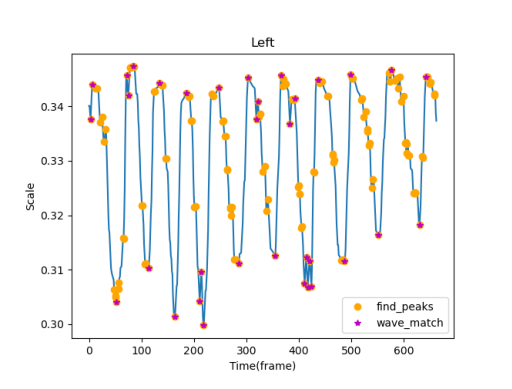

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

# Open the PNG image
image = Image.open("./plots/Find_peaks_wave_match/5dc3f8b18d8f0d06c631b3f2_L.png")
# Display the image below the code cell
plt.imshow(image)
plt.axis('off')  # Hide axis ticks and labels
plt.show()

In [39]:
import random 
list_ = os.listdir('./plots/Find_peaks_wave_match')
randlist_ = random.sample(list_, 10)
randlist_ = list(map(lambda x: os.path.join("./plots/Find_peaks_wave_match", x), randlist_))

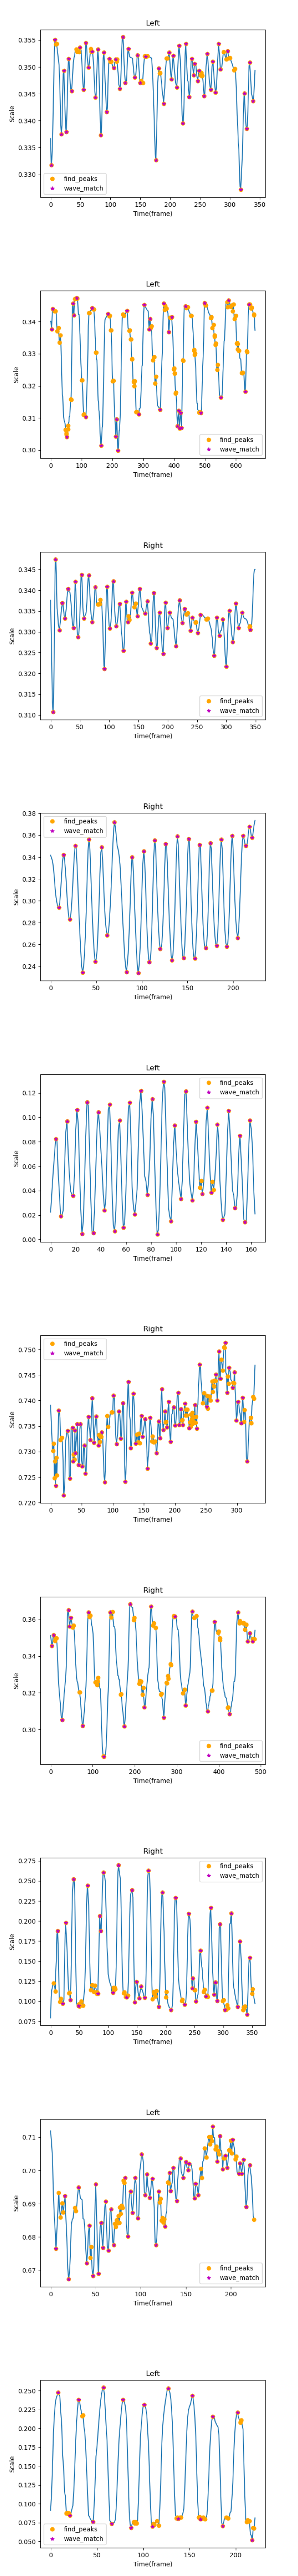

In [42]:
randlist_
num_rows = 1
num_cols = len(randlist_)

# Create a plot with subplots
fig, axes = plt.subplots(num_cols, num_rows, figsize=(100, 80))

# Loop through the images and plot them in the subplots
for i, path in enumerate(randlist_):
    image = Image.open(path)
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis ticks and labels

# Show the plot
plt.show()